In [4]:
import torch
from torch import sigmoid

In [19]:
a = torch.rand((100,100))
result = torch.sigmoid(a)

In [20]:
1 / (1 + torch.exp(-a)) == result

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True]])

(array([ 886.,  941.,  933.,  973.,  974., 1034., 1029.,  989., 1089.,
        1152.]),
 array([0.5000155 , 0.52311814, 0.5462208 , 0.5693235 , 0.5924261 ,
        0.61552876, 0.6386314 , 0.66173404, 0.68483675, 0.7079394 ,
        0.731042  ], dtype=float32),
 <BarContainer object of 10 artists>)

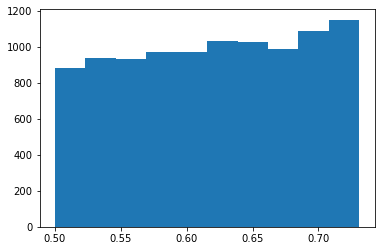

In [21]:
from matplotlib import pyplot as plt
test = 1 / (1 + torch.exp(-a))
plt.hist(test.flatten().numpy())

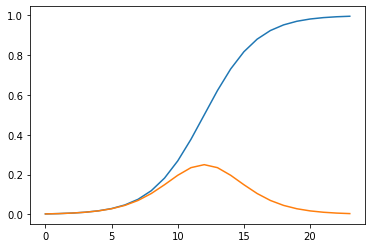

In [36]:
a = torch.arange(-6, 6, 0.5)

from matplotlib import pyplot as plt
test = 1 / (1 + torch.exp(-a))
plt.plot(test.numpy())
plt.plot(test*(1-test))
plt.show()

In [35]:
test*(1-test)

tensor([0.0025, 0.0041, 0.0066, 0.0109, 0.0177, 0.0285, 0.0452, 0.0701, 0.1050,
        0.1491, 0.1966, 0.2350, 0.2500, 0.2350, 0.1966, 0.1491, 0.1050, 0.0701,
        0.0452, 0.0285, 0.0177, 0.0109, 0.0066, 0.0041])

In [83]:
q = torch.rand((2, 10, 3, 3))
sigmoid_q = 1 / (1 + torch.exp(-q))

In [84]:
dim = 2 if len(q.shape) == 4 else 1
print(dim)

rho_hat = torch.mean(sigmoid(q).flatten(dim), dim)
print(rho_hat)
rho_hat = torch.mean(sigmoid_q.flatten(dim), dim)
print(rho_hat)

2
tensor([[0.6188, 0.6059, 0.6119, 0.6375, 0.6405, 0.6120, 0.5749, 0.6471, 0.6229,
         0.6103],
        [0.6307, 0.6139, 0.6190, 0.6097, 0.6305, 0.5888, 0.6048, 0.5862, 0.6649,
         0.6429]])
tensor([[0.6188, 0.6059, 0.6119, 0.6375, 0.6405, 0.6120, 0.5749, 0.6471, 0.6229,
         0.6103],
        [0.6307, 0.6139, 0.6190, 0.6097, 0.6305, 0.5888, 0.6048, 0.5862, 0.6649,
         0.6429]])


In [85]:
rho = torch.ones(rho_hat.shape).to(q.device) * 0.05

In [86]:
torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)), axis=0)

tensor([1.5125, 1.4412, 1.4672, 1.5082, 1.5662, 1.3976, 1.3505, 1.4790, 1.6120,
        1.5231])

In [87]:
def kl_divergence(p: float, q: torch.Tensor, apply_sigmoid=True) -> torch.Tensor:
    '''
        Kullback-Leibler (KL) divergence between a Bernoulli random variable with mean
        p and a Bernoulli random variable with mean q.

        For convolutional output tensor (shape B,C,H,W) the kl divergence is estimated per
        channel.

        Params
        ------
            p: float
                Sparsity parameter, typically a small value close to zero (i.e 0.05).

            q: torch.Tensor
                The output of a layer.

            apply_sigmoid: Bolean
                Indicate if it is necessary to apply sigmoid function to q in order to
                obtain the probability distribution.
        Return
        ------
            kl divergence estimation: torch.Tensor
                In general return a unique value but in convolutional output the tensor
                shape is defined by the number of Channels, i.e shape [1, C].
    '''
    # check if tensor belong to a convolutional output or not
    dim = 2 if len(q.shape) == 4 else 1

    q = sigmoid(q) if apply_sigmoid else q # sigmoid because we need the probability distributions

    rho_hat = torch.mean(q.flatten(dim), dim) 
    rho = torch.ones(rho_hat.shape).to(q.device) * p
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)), axis=0)

In [88]:
kl_divergence(0.05, q)

tensor([1.5125, 1.4412, 1.4672, 1.5082, 1.5662, 1.3976, 1.3505, 1.4790, 1.6120,
        1.5231])

In [91]:
kl_divergence(0.05, sigmoid_q, apply_sigmoid=False)

tensor([1.5125, 1.4412, 1.4672, 1.5082, 1.5662, 1.3976, 1.3505, 1.4790, 1.6120,
        1.5231])

In [97]:
B,_,H,W = sigmoid_q.shape
kl_loss = kl_divergence(0.05, sigmoid_q, apply_sigmoid=False)[None,:,None,None]

In [101]:
print(B, H, W)
print(kl_loss.expand(B, -1, H, W).shape)

2 3 3
torch.Size([2, 10, 3, 3])
